# Introduction to Lagrangian mechanics

In Lagrangian mechanics, we describe motion using energy instead of forces. The main idea is the Lagrangian, a quantity that tells us how the system behaves. It is defined as the difference between the kinetic energy and potential energy ([Cranmer et al., 2020](https://arxiv.org/pdf/2003.04630)):

$$
L = T - V
$$

Here,
`T` is the kinetic energy (how fast something moves), and
`V` is the potential energy (energy due to position).
This simple equation forms the base of many physical systems and helps us find how objects move using the Euler–Lagrange equation.

# LNN vs Traditional Neural Networks

<p align="center">
  <img src="https://greydanus.github.io/assets/lagrangian-nns/overall-idea.png" width="800"/>
</p>

<p align="center">
  <em>Figure: Overall idea of Lagrangian Neural Networks. Source: <a href="#Bibliography">[4]</a></em>
</p>

Traditional neural networks are excellent at fitting data but usually do not respect the underlying physics of dynamical systems. Lagrangian Neural Networks (LNNs) take a physics-informed approach — instead of directly predicting the next state of a system, they learn the Euler Lagrangian function that defines the system's behavior.

An LNN learns a scalar-valued function L(q, q̇) which represents the difference between kinetic and potential energy of the system. Once trained, the network outputs this Lagrangian, and we use the Euler-Lagrange equations to compute the system's time evolution.

The dynamics of the system are obtained from:

$$
\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}_i} \right) - \frac{\partial L}{\partial q_i} = 0
$$

This equation expresses how the generalized coordinates qi (such as positions or angles) evolve over time based on the learned Lagrangian.
Instead of learning motion directly, the LNN ensures that the learned dynamics conserve physical consistency, such as obeying energy relationships and realistic motion patterns.

# Spring Pendulum Experiment

In this tutorial, we are simulating LNN on Spring Pendulum experiment

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/4/47/2D_spring_Pendulum.gif" width="500" height="500"/>
</p>

<p align="center">
  <em>Figure: Spring Pendulum illustration. Source: <a href="#Bibliography">[5]</a></em>
</p>


A spring pendulum is a simple mechanical system that combines two types of motion — the oscillation of a spring (stretching and compressing) and the swinging motion of a pendulum. It consists of a mass attached to the end of a spring, which in turn is fixed to a support. The motion of the mass can therefore occur both radially (along the spring) and angularly (as it swings).

We describe the system using two generalized coordinates:
* x: the extension or compression of the spring from its natural length
* θ: the angular displacement of the mass from the vertical

Kinetic Energy (T) :
$$
T = \frac{1}{2} m \!\left(\dot{x}^{2} + (l_{0} + x)^{2}\dot{\theta}^{2}\right)
$$

Potential Energy (V) :     
$$
V = \frac{1}{2} k x^{2} - g m (l_{0} + x)\cos\theta
$$

Lagrangian (L) :     
$$
L[x,\dot{x},\theta,\dot{\theta}]
=
\frac{1}{2} m \!\left(\dot{x}^{2} + (l_{0} + x)^{2}\dot{\theta}^{2}\right)
-\frac{1}{2} k x^{2}
+ g m (l_{0} + x)\cos\theta
$$

Equation of Motion :    
Using the Euler-lagrange equations, we derive the accelerations for both x and θ:

$$
\ddot{x} = (l_{0} + x)\,\dot{\theta}^{2} - \frac{k}{m}\,x + g\cos\theta
$$

$$
\ddot{\theta} = -\frac{g}{l_{0} + x}\sin\theta \;-\; \frac{2\dot{x}\,\dot{\theta}}{\,l_{0} + x\,}
$$






# Explanation of Dataset script

### 1. q2xy(ql)

This function converts polar coordinates (r, θ) to Cartesian coordinates (x, y). It's useful if we want to visualize the pendulum's motion in 2D space.
The transformation used is:  
$$
x = r sin(θ) \\
y = -r cos(θ)
$$

### 2. compute_accelerations(q, qt)

This function calculates the accelerations $ (\ddot{r}, \ddot{\theta})$ based on the current state -- i.e, the generalized coordinates q = [r, θ] and their velocities qt = $(\dot{r}, \dot{\theta})$

### 3. solve_spring_pendulum_ode(q0, qt0, t)

This function solves the system’s ODEs (Ordinary Differential Equations) over time using SciPy’s `odeint`.
* It takes initial conditions for position `q0` and velocity `qt0`
* Then computes how the state evolves over the given time steps `t`.
The result is a complete trajectory of a system i.e., how x and θ change over time

### 4. get_state_derivative(x, t)

Once we have the full trajectory, this function computes the corresponding velocities and accelerations for each time step.
It returns:
* $(\dot{r}, \dot{\theta})$ -- velocities
* $ (\ddot{r}, \ddot{\theta})$ -- accelerations

### 5. get_dataset(...)

This is the main function that puts everything together:
1. Generates a sequence of time steps.
2. Defines initial conditions (r0 = 1.1, θ0 = 0.5)
3. Solves the ODEs using `solve_spring_pendulum_ode`
4. Computes derivaties (velocities and accelerations)
5. Splits the data into training and testing sets.

The resulting dataset includes:
* x: inputs states -> $[r, \theta, \dot{r}, \dot{\theta}]$
* dx : target acclerations -> $[\ddot{r}, \ddot{\theta}]$






In [2]:
import numpy as np
import torch
from scipy.integrate import odeint

def q2xy(ql):
  '''
  Polar coords to xy
  '''
  try:
      xy = np.zeros_like(ql)
      sin = np.sin
      cos = np.cos
  except:
      xy = torch.zeros_like(ql)
      sin = torch.sin
      cos = torch.cos

  xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
  xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
  return xy

def compute_accelerations(q, qt, g=10, k=10):
    '''
    q is array of genralise coords, [r, theta]
    qt is array of genralise coords, [rdt, thetadt]

    returns time derivative of q.
    '''
    qdtt = np.zeros_like(q)

    qdtt[:, 0] = q[:, 0]*qt[:, 1]**2 - g*(1-np.cos(q[:, 1])) - 2*k*(q[:, 0]-1)
    qdtt[:, 1] = (-g*np.sin(q[:, 1]) -2*qt[:, 0]*qt[:, 1])/q[:, 0]

    return qdtt

def solve_spring_pendulum_ode(q0, qt0, t,):

    x0 = np.append(q0, qt0)

    def f_anal(x, t):
        d = np.zeros_like(x)
        d[:2] = x[2:]
        d[2:] = np.squeeze(compute_accelerations(np.expand_dims(x[:2], axis=0), np.expand_dims(x[2:], axis=0)))
        # print(x, d)
        return d

    return odeint(f_anal, x0, t, rtol=1e-10, atol=1e-10)

def get_state_derivatives(x, t):
  d = np.zeros_like(x)
  d[:, :2] = x[:, 2:] # velocities [ x_dot, theta_dot ]
  d[:, 2:] = compute_accelerations(x[:, :2], x[:, 2:]) # accelerations [ x_ddot, theta_ddot ]
  return d

def get_dataset(t0=0, tlast=10, train_split=0.8):
    data = {'meta': locals()}

    timesteps = torch.tensor(np.linspace(t0, tlast, 1500)).float()
    q0 = np.array([1.1, 0.5])  # initial position
    qt0 = np.array([0.0, 0.0])  # initial velocity

    X = torch.tensor(solve_spring_pendulum_ode(q0, qt0, timesteps)).float()
    derivatives = torch.tensor(get_state_derivatives(X, timesteps)).float()

    # inputs and outputs
    data['x'] = X.numpy()
    data['dx'] = derivatives[:, 2:].numpy()

    # train/test split
    split_ix = int(len(data['x']) * train_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]

    data = split_data
    return data


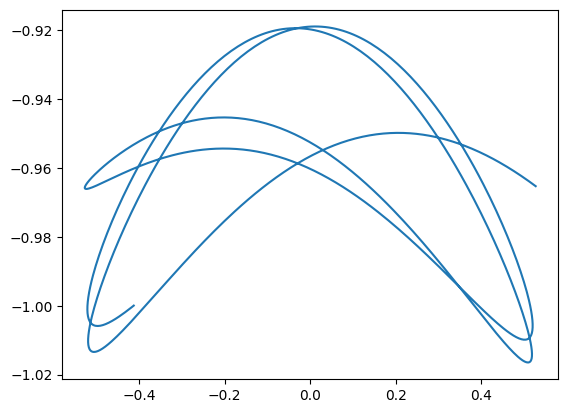

In [3]:
import matplotlib.pyplot as plt

q0 = np.array([1.1, 0.5])
qt0 = np.array([0.0, 0.0])
t = np.arange(0, 5, 0.005)
path = solve_spring_pendulum_ode(q0, qt0, t)
xy = q2xy(path)

plt.plot(xy[:, 0], xy[:, 1])

## Setup

In [7]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

'2.8.1.dev'

In [4]:
from deepchem.data import NumpyDataset
from deepchem.models.torch_models.lnn import LNN, LNNModel


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [10]:

# loading dataset in NumpyDataset
data = get_dataset()
train_dataset = NumpyDataset(X=data['x'], y=data['dx'])
test_dataset = NumpyDataset(X=data['test_x'], y=data['test_dx'])

# creating model instance
model = LNNModel(n_dof=2, d_hidden=(64, 64))

# training for 200 epochs
model.fit(train_dataset, nb_epoch=200)

0.05717297554016113

In [11]:
predictions = model.predict(test_dataset)

print(test_dataset.y[:1])
print(predictions[:1])

[[ 1.54082   -3.7345955]]
[[ 1.4923593 -3.910767 ]]


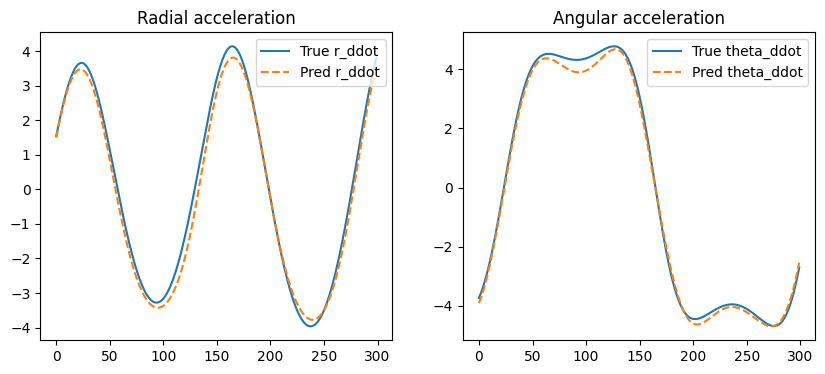

In [12]:
y_true = test_dataset.y
y_pred = predictions

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(y_true[:,0], label="True r_ddot")
plt.plot(y_pred[:,0], '--', label="Pred r_ddot")
plt.legend()
plt.title("Radial acceleration")

plt.subplot(1,2,2)
plt.plot(y_true[:,1], label="True theta_ddot")
plt.plot(y_pred[:,1], '--', label="Pred theta_ddot")
plt.legend()
plt.title("Angular acceleration")
plt.show()


/tmp/ipython-input-2884541391.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([test_dataset.y.flatten(), predictions.flatten()],


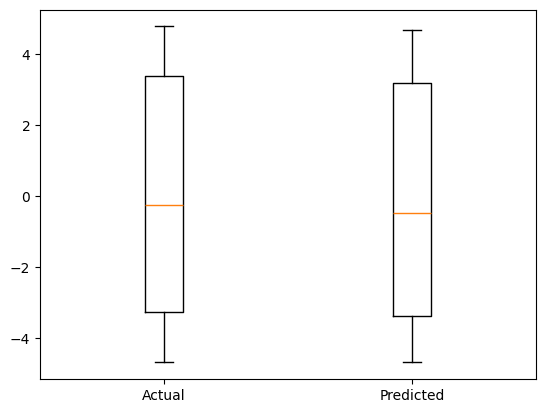

In [13]:
plt.boxplot([test_dataset.y.flatten(), predictions.flatten()],
            labels=['Actual', 'Predicted'])
plt.show()

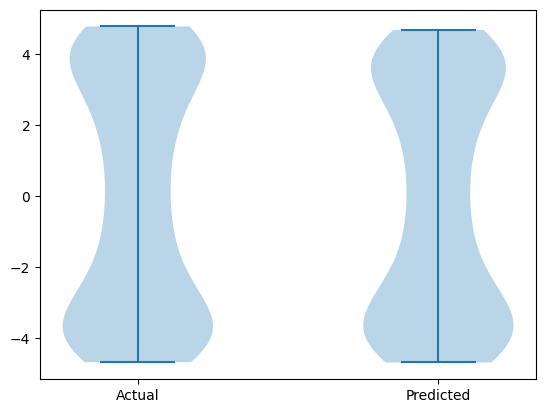

In [14]:
plt.violinplot([test_dataset.y.flatten(), predictions.flatten()])
plt.xticks([1, 2], ['Actual', 'Predicted'])
plt.show()

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!



# References

[1] Cranmer, S., Greydanus, S., Hoyer, S., Battaglia, P., Spergel, D., & Ho, S. (2020). *Lagrangian Neural Networks*. [arXiv:2003.04630](https://arxiv.org/pdf/2003.04630)

[2] Github repository - [Lagrangian Neural Networks](https://github.com/MilesCranmer/lagrangian_nns)

[3] Sam Greydanus. (2020). Blog Post - [https://greydanus.github.io/2020/03/10/lagrangian-nns/](https://greydanus.github.io/2020/03/10/lagrangian-nns/)

[4] LNNvsNN overall architecture : [https://astroautomata.com/assets/images/lnn.jpeg](https://astroautomata.com/assets/images/lnn.jpeg)

[5] Spring pendulum gif : [https://upload.wikimedia.org/wikipedia/commons/4/47/2D_spring_Pendulum.gif](https://upload.wikimedia.org/wikipedia/commons/4/47/2D_spring_Pendulum.gif)


In [ ]:
@manual{Intro10,
 title={Introduction to Lagrangian Neural Networks},
 organization={DeepChem},
 author={Abhay Shinde},
 howpublished = {\url{https://github.com/deepchem/deepchem/tree/master/examples/tutorials/Introduction_to_Lagrangian_Neural_Network.ipynb}},
 year={2025},
}